In [1]:
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torch
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


sys.path.append('../')

In [2]:
from model.main import DepthNetModule
from utils.io import prepare_input_image

In [3]:
# Load the model checkpoint
model_path = '../checkpoints/NyuBest5.ckpt'
model = DepthNetModule.load_from_checkpoint(model_path)
model.eval()
model = model.to('cuda')

Using cache found in /home/ashkanganj/.cache/torch/hub/facebookresearch_dinov2_main
/home/ashkanganj/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ashkanganj/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ashkanganj/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
/home/ashkanganj/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/ashkanganj/anaconda3/envs/torch/lib/python3.10/

Run with random init
Loading weights:  None


In [4]:
def zoom_2x(image_tensor, zoom_factor=2):
    b, c, h, w = image_tensor.shape
    new_h, new_w = h // zoom_factor, w // zoom_factor

    # Calculate the cropping coordinates
    top = (h - new_h) // 2
    left = (w - new_w) // 2

    # Crop the image
    cropped = image_tensor[:, :, top:top+new_h, left:left+new_w]

    # Resize back to original size
    zoomed = F.interpolate(cropped, size=(
        h, w), mode='bilinear', align_corners=True)
    return zoomed

In [5]:
data_dir = '../server/images3'
focal_stack, rgb_img, focus_dist = prepare_input_image(data_dir)

Focal stack shape: torch.Size([1, 5, 3, 480, 640])
RGB image shape: torch.Size([1, 3, 480, 640])
Focus distances shape: torch.Size([1, 5])


In [6]:
# Apply 2x zoom effect
zoomed_focal_stack = torch.stack(
    [zoom_2x(focal_stack[:, i]) for i in range(focal_stack.shape[1])], dim=1)
zoomed_rgb_image = zoom_2x(rgb_img)

print(zoomed_rgb_image.shape)

torch.Size([1, 3, 480, 640])


In [7]:
# Disable gradient computation for inference (reduces memory usage and speeds up computation)
with torch.no_grad():
    out = model(rgb_img, focal_stack, focus_dist)

metric_depth = out[0].squeeze().cpu().numpy()
metric_dfv = out[-1].squeeze().cpu().numpy()


# Disable gradient computation for inference (reduces memory usage and speeds up computation)
with torch.no_grad():
    out_zoom = model(zoomed_rgb_image, zoomed_focal_stack, focus_dist)

metric_depth_zoom = out_zoom[0].squeeze().cpu().numpy()
metric_dfv_zoom = out_zoom[-1].squeeze().cpu().numpy()

/home/ashkanganj/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
/home/ashkanganj/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [8]:
rgb_img = rgb_img.squeeze().cpu().numpy().transpose(1, 2, 0)
rgb_img = (rgb_img * 255).astype(np.uint8)

zoomed_rgb_image = zoomed_rgb_image.squeeze().cpu().numpy().transpose(1, 2, 0)
zoomed_rgb_image = (zoomed_rgb_image * 255).astype(np.uint8)
print('Original depth Ours', metric_depth_zoom[330, 330])
print('Zoomed depth ours', metric_depth_zoom[300, 310])

print('original dfv', metric_dfv[330, 330])
print('zoomed dfv', metric_dfv_zoom[300, 310])

Original depth Ours 0.70849645
Zoomed depth ours 0.70144254
original dfv 0.66199625
zoomed dfv 0.8041075


In [9]:
print(metric_depth.shape)
print(focus_dist)

(480, 640)
tensor([[0.5000, 0.6500, 0.8000, 0.9500, 1.3000]], device='cuda:0')


(-0.5, 639.5, 479.5, -0.5)

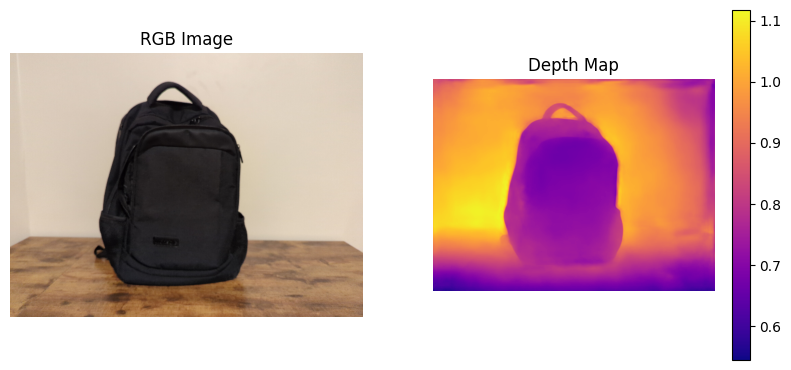

In [10]:
# visialize the results RGB + depth
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(rgb_img)
plt.title('RGB Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(metric_depth, cmap='plasma')
plt.title('Depth Map')
plt.colorbar()
plt.axis('off')

In [11]:
def save_vis_two_rows(rgb1, rgb2, pred1, pred2, dfv1, dfv2, gs_depth1, gs_depth2, dir_name='default'):
    """
    Displays two sets of images in two rows: RGB, Prediction, DFV, and Depth Anything.

    Parameters:
    - rgb1, rgb2: Two RGB images.
    - pred1, pred2: Two predictions (Ours).
    - dfv1, dfv2: Two DFV images.
    - gs_depth1, gs_depth2: Two Depth Anything images.
    - dir_name: Directory name to save the image visualization.
    """
    # pred viz
    outdir = '../results/imgs'
    img_save_pth = os.path.join(os.path.abspath(outdir), 'scale_ambiguity')

    # Create directory if it doesn't exist
    if not os.path.isdir(img_save_pth):
        os.makedirs(img_save_pth)

    # Create a 2-row and 4-column grid for two sets of images
    fig, axs = plt.subplots(2, 4, figsize=(8, 3))  # 12x6 for two rows

    # Adjust the space between the images (reduce hspace for tighter rows)
    # Less vertical space between rows
    plt.subplots_adjust(wspace=0.04, hspace=0.05)

    # Set font to Times New Roman (though we won't need it for titles)
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 11

    # List of image sets for easy looping (RGB, Prediction, DFV, Depth Anything)
    image_sets = [(rgb1, pred1, dfv1, gs_depth1),
                  (rgb2, pred2, dfv2, gs_depth2)]

    for i, (rgb, pred, dfv, gs_depth) in enumerate(image_sets):
        # Plot RGB image
        axs[i, 0].imshow(rgb)
        axs[i, 0].axis('off')

        # Set display range for depth images
        MAX_DISP, MIN_DISP = 3.2, 0.2

        # Plot Prediction (Ours)
        im1 = axs[i, 1].imshow(pred, cmap='plasma',
                               vmin=MIN_DISP, vmax=MAX_DISP)
        axs[i, 1].axis('off')

        # Plot DFV
        im2 = axs[i, 2].imshow(
            dfv, cmap='plasma', vmin=MIN_DISP, vmax=MAX_DISP)
        axs[i, 2].axis('off')

        # Plot Depth Anything
        im3 = axs[i, 3].imshow(gs_depth, cmap='plasma',
                               vmin=MIN_DISP, vmax=MAX_DISP)
        axs[i, 3].axis('off')

    # Save the figure
    plt.savefig(os.path.join(
        img_save_pth, f'{dir_name}_pred_viz_diff.png'), bbox_inches='tight', pad_inches=0)
    plt.close()

In [12]:
# load depth anything
depthAnything = np.load('../results/imgs/DepthAnythingData/scaleAmbiguity/depthAnything-image0.npy')
depthAnything_2x = np.load('../results/imgs/DepthAnythingData/scaleAmbiguity/depthAnything-image3.npy')

In [13]:
save_vis_two_rows(rgb_img, zoomed_rgb_image, metric_depth, metric_depth_zoom,
                  metric_dfv, metric_dfv_zoom, depthAnything, depthAnything_2x, 'scale_ambiguity')